# Demo: Simulation of Tyrosine NMR Spectrum

## UNDER CONSTRUCTION
This notebook shows a goal for what the **nmrsim** package should enable. There are currently two issues:
1. Currently individual Spectrum components can't have individual line widths. Need to implement a peak width attribute in the Multiplet and SpinSystem classes, in order to add two broad singlets to the spectrum.
2. the nmrsim.plt routines are convenient for quick plots, but for entire spectrums their small size and low resolution is noticeable (e.g. misleading signal intensities). Need to either provide ways to customize the plots (e.g. have `plt.mplplot` return the actual matplotlib object for customization, or use the peaklist data in another visualization library).

This tutorial is adapted from the [nmrmint](https://nmrmint.readthedocs.io/en/latest/tutorial.html) tutorial. 

*(If you're interested in an app for the simulation of a complete NMR spectrum, see the [nmrmit project](https://github.com/sametz/nmrmint).)*

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
%config InlineBackend.figure_format = 'svg'  # makes inline plot look less blurry
%matplotlib inline
home_path = os.path.abspath(os.path.join('..'))
if home_path not in sys.path:
    sys.path.append(home_path)

tests_path = os.path.abspath(os.path.join('..', 'tests'))
if tests_path not in sys.path:
    sys.path.append(tests_path)

In [2]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

Here is the data for the spectrum of tyrosine in D<sub>2</sub>O:

    1H NMR (500 MHz, Deuterium Oxide) δ 7.18 (d, J = 8.5 Hz, 1H), 6.89 (d, J = 8.5 Hz, 1H), 3.93 (dd, J = 7.7, 5.1 Hz, 1H), 
    3.19 (dd, J = 14.7, 5.1 Hz, 1H), 3.05 (dd, J = 14.7, 7.8 Hz, 1H).

Data is provided in ppm on a 500 MHz spectrometer. We'll create a function to perform ppm-to-Hz conversions for us:

In [3]:
def ppm_to_hz(ppm, spec_freq):
    """Given a chemical shift in ppm and spectrometer frequency in MHz, return the corresponding chemical shift in Hz."""
    return [d * spec_freq for d in ppm]

The two "doublets" in the aromatic region actually comprise an AA'XX' system. This 4-nuclei spin system can be modeled using the SpinSystem class:

In [4]:
from nmrsim import SpinSystem

Create a frequency list (in Hz) for the A, A', X, and X' nuclei:

In [5]:
v_aaxx = ppm_to_hz([7.18, 7.18, 6.89, 6.89], 500)
v_aaxx

[3590.0, 3590.0, 3445.0, 3445.0]

For the *J* values, as a first approximation we'll assume J<sub>AX</sub> (an J<sub>A'X'</sub>) are close to the faux-doublet splitting of 8.5 Hz. We'll estimate that J<sub>AA'</sub> and J<sub>XX'</sub> are about 2 Hz, and that the J<sub>AX'</sub> and J<sub>A'X</sub> couplings are about 0 Hz.

In [6]:
j_aaxx = [[0, 2, 8.5, 0],
          [2, 0, 0, 8.5],
          [8.5, 0, 0, 2],
          [0, 8.5, 2, 0]]


In [7]:
aaxx = SpinSystem(v_aaxx, j_aaxx)


In [8]:
from nmrsim.plt import mplplot, mplplot_lineshape

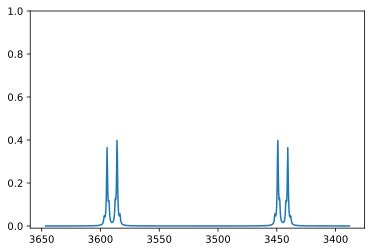

In [9]:
mplplot(aaxx.peaklist());

Next, we'll create the ABX system for the aliphatic protons. For this exercise, we are assuming that the coupling constants that the first-order analysis provided are close enough. 

*(If accuracy is critical, there are methods for solving the ABX system. For example, see https://www.chem.wisc.edu/areas/reich/nmr/05-hmr-12-abx.htm#solving%20ABX )*

In [10]:
v_abx = ppm_to_hz([3.93,3.19, 3.05], 500)
j_abx = [[0, 5.1, 7.75],
        [5.1, 0, -14.7],  # geminal Js should be negative
        [7.75, -14.7, 0]]
abx = SpinSystem(v_abx, j_abx)

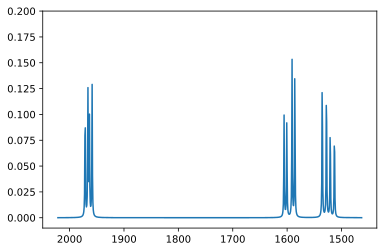

In [11]:
mplplot(abx.peaklist(), y_max=0.2);

These spin systems can be combined into a spectrum:

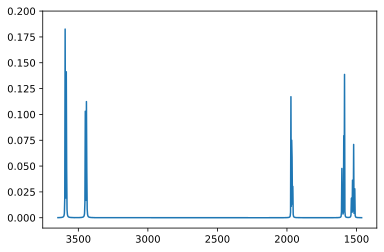

nmrsim._classes.Spectrum

In [12]:
tyr_spectrum = aaxx + abx
mplplot(tyr_spectrum.peaklist(), y_max=0.2)
type(tyr_spectrum)

Addition of the two SpinSystem objects returned a Spectrum object.

If peak intensities look off, try using more data points for the lineshape. Here is the same example with ~ 10 data points per Hz:

21838


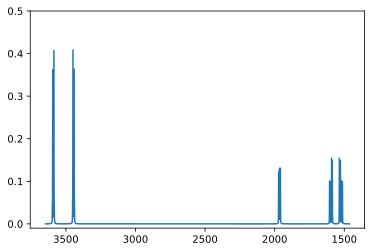

In [13]:
points=int((tyr_spectrum.vmax - tyr_spectrum.vmin) * 10)
print(points)
mplplot(tyr_spectrum.peaklist(), y_max=0.5, points=points);

The Spectrum class can also provide lineshape data for the spectrum:

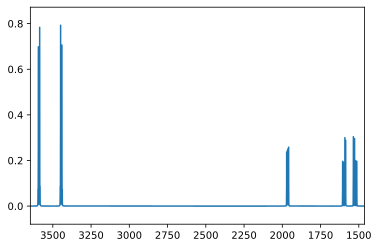

In [14]:
mplplot_lineshape(*tyr_spectrum.lineshape(points=points));

The Spectrum.linewidth() method has an advantage over the .peaklist() method: it can take into account the linewidths specified by its component Multiplet/SpinSystem objects. The default value is 0.5 Hz, but this can be set to other values.


In D<sub>2</sub>O, the -OH and -NH protons are exchanged for D and are not seen in the spectrum. If we wanted to include these in the spectrum for pedagogical reasons, we could create broad singlets with the Multiplet class:

In [15]:
from nmrsim import Multiplet

In [16]:
# frequency in Hz, integration, [empty list for no coupling constants], peakwidth = 20 Hz
nh3 = Multiplet(8.3 * 500, 3, [], w=100)  
tyr_oh = Multiplet(9.8 * 500, 1, [], w=100)
tyr_spectrum2 = tyr_spectrum + nh3 + tyr_oh

A Spectrum can have its .vmin and .vmax attributes reset to give a full spectral window (defaults are to provide a 50 Hz margin):

In [17]:
tyr_spectrum2.default_limits()  # resets limits, and returns vmin, vmax tuple

(1462.9870013439968, 4950.0)

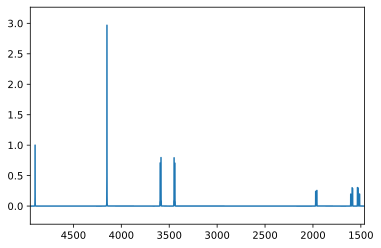

In [18]:
points2 = int((tyr_spectrum2.vmax - tyr_spectrum2.vmin) * 10)
mplplot_lineshape(*tyr_spectrum2.lineshape(points=points2));

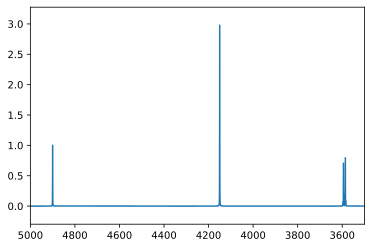

(array([3500.        , 3500.05000167, 3500.10000333, ..., 4999.89999667,
        4999.94999833, 5000.        ]),
 array([5.83681868e-05, 5.83074562e-05, 5.82469735e-05, ...,
        6.65399407e-06, 6.64769100e-06, 6.64139733e-06]))

In [19]:
tyr_spectrum2.vmax = 5000
tyr_spectrum2.vmin = 3500
mplplot_lineshape(*tyr_spectrum2.lineshape(points=30000))

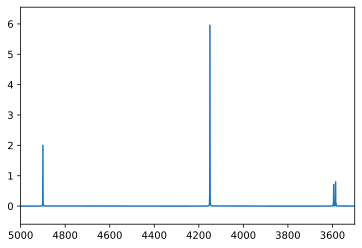

(array([3500.        , 3500.05000167, 3500.10000333, ..., 4999.89999667,
        4999.94999833, 5000.        ]),
 array([5.88438615e-05, 5.87832014e-05, 5.87227893e-05, ...,
        1.31760507e-05, 1.31634528e-05, 1.31508738e-05]))

In [20]:
s3 = tyr_oh + nh3 + tyr_spectrum
s3.vmax = 5000
s3.vmin = 3500
mplplot_lineshape(*s3.lineshape(points=30000))

In [24]:
tyr_spectrum.peaklist()

[(1512.9870013439968, 0.19583324850958125),
 (1520.718644457299, 0.2013778490472962),
 (1527.6861839955252, 0.29536288026878826),
 (1535.4178271088267, 0.30742701638738923),
 (1585.8375269350263, 0.2964083061152336),
 (1590.9550664732524, 0.3063822909887538),
 (1600.5367095865547, 0.19670092820920268),
 (1605.65424912478, 0.20051086979548483),
 (1958.627106417921, 0.25793746490570185),
 (1963.7446459561463, 0.25086520876159113),
 (1966.3587495312222, 0.24895280366333447),
 (1971.4762890694487, 0.24224113334764272),
 (3438.186448991646, 0.06546198482525473),
 (3440.62201915445, 0.23534761493248882),
 (3440.6255378677383, 0.11768497164582371),
 (3440.62553786774, 0.23536994329172034),
 (3440.625537867741, 0.11768497164589686),
 (3442.1796001054836, 0.1713083985466791),
 (3447.571475629997, 0.18451316302770587),
 (3449.125537867739, 0.26463005672573503),
 (3449.1255378677392, 0.13231502836290343),
 (3449.125537867742, 0.13231502836283043),
 (3449.128868040614, 0.26465490885078863),
 (3451

In [21]:
from nmrsim.math import get_maxima

In [22]:
max1 = get_maxima(tyr_spectrum.lineshape())

MAXIMUM FOUND AT: 
(3586.357947434293, 0.1779850572125637)
MAXIMUM FOUND AT: 
(3593.8673341677095, 0.14835087423744053)
MAXIMUM FOUND AT: 
(4149.561952440551, 0.7370706301786539)
MAXIMUM FOUND AT: 
(4900.500625782228, 0.19960053328568814)


In [23]:
s3 = tyr_

NameError: name 'tyr_' is not defined

In [ ]:
x1, y1 = tyr_spectrum.lineshape()
x2, y2 = tyr_spectrum.lineshape()


In [ ]:
tyr_oh.peaklist()

In [ ]:
from nmrsim.plt import add_lorentzians

In [ ]:
x = np.linspace(4800, 5000, 2000)
y_thin = add_lorentzians(x, tyr_oh.peaklist(), 0.5)
y_fat = add_lorentzians(x, tyr_oh.peaklist(), 50)

In [ ]:
mplplot_lineshape(x, y_thin)
mplplot_lineshape(x, y_fat);

In [ ]:
# def interactive_ab(va=110, vb=100, J=10, k=0.1, w=0.5):
#     args = (va, vb, J, k, w)
#     x, y = dnmr_AB(*args)
#     obj = go.Scatter(x=x, y=y)
#     data = [obj]
#     iplot(data)
x = np.linspace(-250.0, 4000.0, 40000)
y = add_lorentzians(x, tyr_spectrum.peaklist(), 0.5)
spectrum = [go.Scatter(x=x, y=y)]
iplot(spectrum)

What if you want the x axis to be in ppm?

In [ ]:
# The following hack shows the need for user-friendly conversions between ppm and hz, and peaklists and lineshapes.
lineshape = mplplot(tyr_spectrum.peaklist())  # returns lineshape x, y data
x, y = lineshape
# print(x)
# print(y)
x_ppm = [v / 500 for v in x]
from nmrsim.plt import mplplot_lineshape
mplplot_lineshape(x_ppm, y, limits=(10.5, -0.5))

In [ ]:
ppm_peaklist


In [ ]:
# Instead of the above, consider adding a method:
tyr_spectrum.linshape()